# АНАЛИЗ ВРЕМЕННЫХ РЯДОВ 

## Лабораторная №1 Выявить в заданном временном ряду аномальные значения по критерию Ирвина. Обнаруженные аномальные значения заменить путем интерполирования по соседним точкам. 
```
Выполнить сглаживание заданного ряда следующими методами: • среднеарифметическая по 5 точкам; 
• средневзвешенная по 5 точкам; 
• средневзвешенная по 7 точкам; 
• средне-хронологическая по 12 точкам; 
• экспоненциальное сглаживание. 
На одной диаграмме построить графики исходного ряда и все сглаженные ряды.
```

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression

from scipy.stats import skew, kurtosis, ttest_1samp
from scipy.optimize import curve_fit

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from scipy import stats

/var/folders/d5/7h_xmkjn47nbw0jsxg5xgvyw0000gn/T/ipykernel_84579/3310339792.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['OrderDate'] = pd.to_datetime(df['OrderDate'], dayfirst=True)


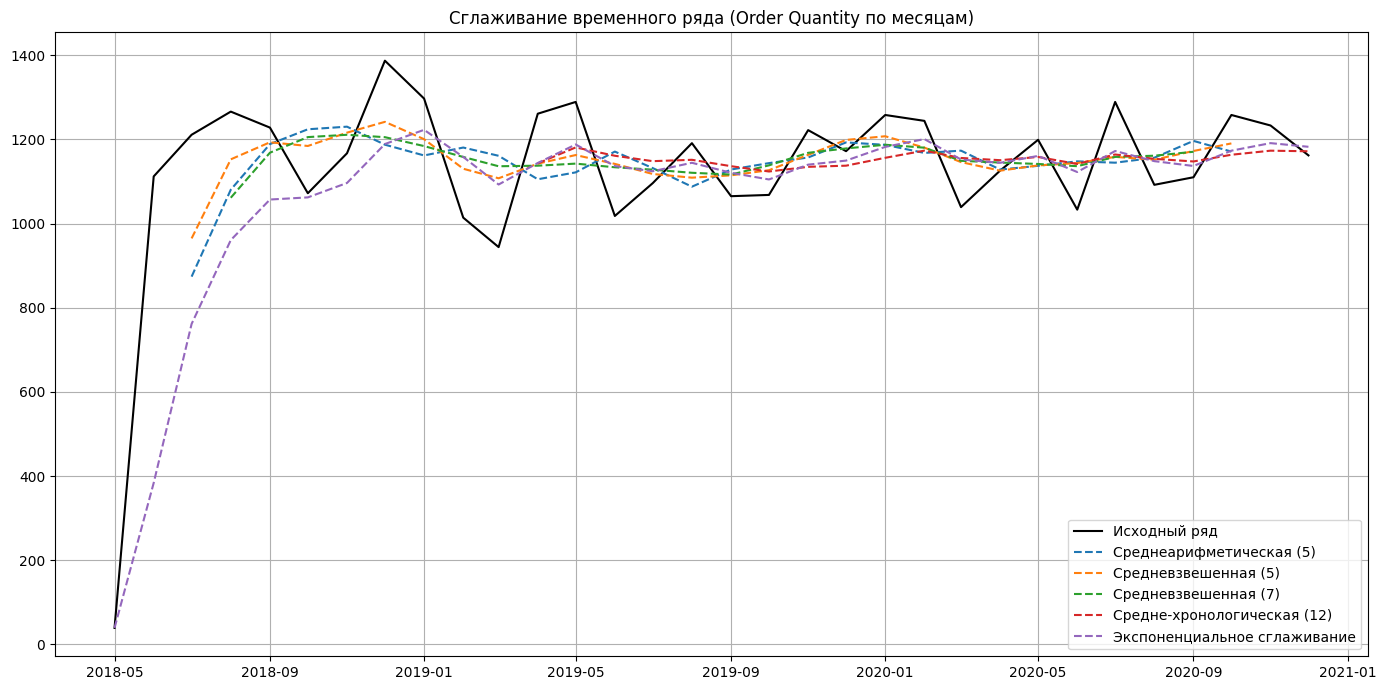

In [99]:
df = pd.read_csv("SalesData.csv")

# Преобразование даты
df['OrderDate'] = pd.to_datetime(df['OrderDate'], dayfirst=True)

# Преобразование чисел с запятыми
df['Unit Cost'] = df['Unit Cost'].str.replace(',', '').astype(float)
df['Unit Price'] = df['Unit Price'].str.replace(',', '').astype(float)

# Агрегация по месяцам: суммарное количество заказов
monthly_series = df.groupby(df['OrderDate'].dt.to_period('M'))['Order Quantity'].sum()
monthly_series.index = monthly_series.index.to_timestamp()

# Функция критерия Ирвина (упрощённый подход, используя Z-оценку)
def irwin_test(series, threshold=1.5):
    diffs = np.abs(series - series.shift(1))
    std = series.std()
    z_scores = diffs / std
    return z_scores > threshold

# Находим аномалии
anomalies = irwin_test(monthly_series)
cleaned_series = monthly_series.copy()
cleaned_series[anomalies] = (monthly_series.shift(1) + monthly_series.shift(-1)) / 2

# Сглаживания
rolling_5 = cleaned_series.rolling(5, center=True).mean()

weights_5 = np.array([1, 2, 3, 2, 1]) / 9
weighted_5 = cleaned_series.rolling(5, center=True).apply(lambda x: np.dot(x, weights_5), raw=True)

weights_7 = np.array([1, 2, 3, 4, 3, 2, 1]) / 16
weighted_7 = cleaned_series.rolling(7, center=True).apply(lambda x: np.dot(x, weights_7), raw=True)

# Средне-хронологическая по 12 точкам
def chronological_average(series):
    weights = np.arange(1, 13)
    return series.rolling(12).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)

chronological_12 = chronological_average(cleaned_series)

# Экспоненциальное сглаживание
exp_smooth = cleaned_series.ewm(alpha=0.3).mean()

# Построение графика
plt.figure(figsize=(14, 7))
plt.plot(monthly_series, label='Исходный ряд', color='black')
plt.plot(rolling_5, label='Среднеарифметическая (5)', linestyle='--')
plt.plot(weighted_5, label='Средневзвешенная (5)', linestyle='--')
plt.plot(weighted_7, label='Средневзвешенная (7)', linestyle='--')
plt.plot(chronological_12, label='Средне-хронологическая (12)', linestyle='--')
plt.plot(exp_smooth, label='Экспоненциальное сглаживание', linestyle='--')
plt.title("Сглаживание временного ряда (Order Quantity по месяцам)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

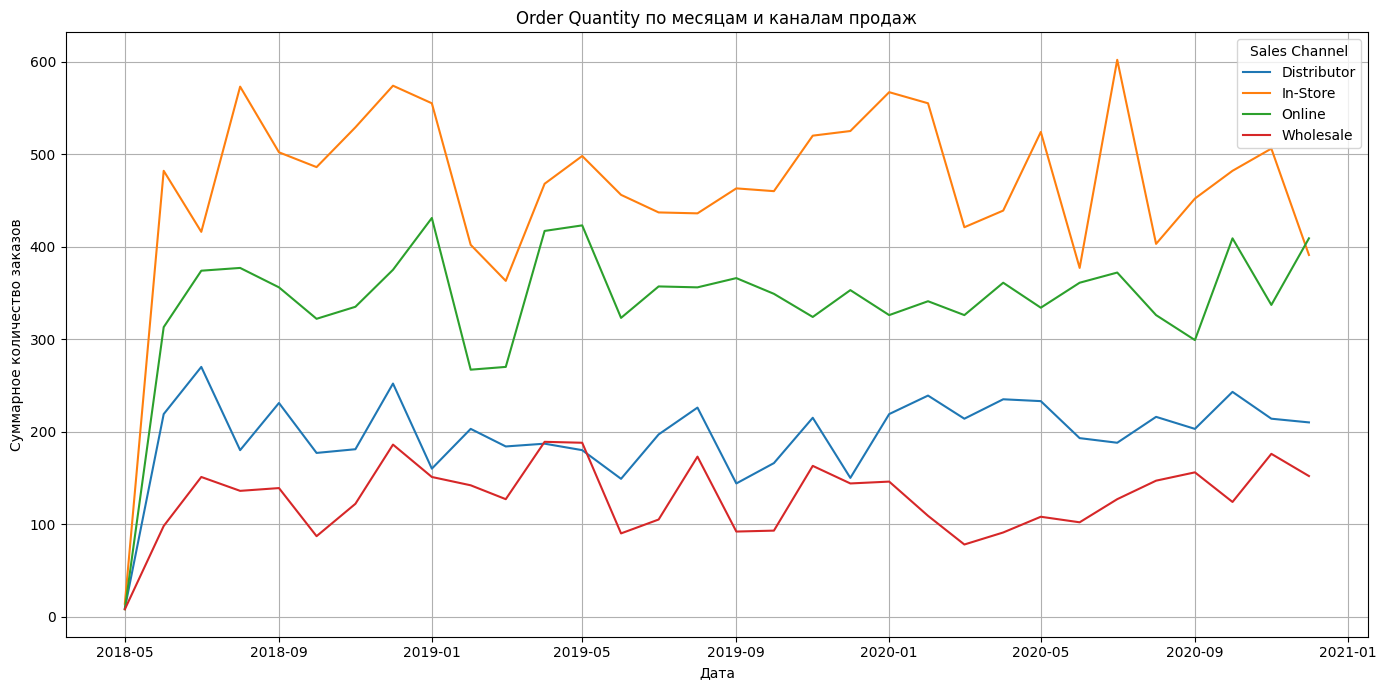

In [100]:
# Группировка по 'Sales Channel' и месяцам: суммарное количество заказов
channel_monthly_series = df.groupby([df['OrderDate'].dt.to_period('M'), 'Sales Channel'])['Order Quantity'].sum().unstack()

# Преобразование индекса обратно в Timestamp
channel_monthly_series.index = channel_monthly_series.index.to_timestamp()

# Визуализация по каждому каналу продаж
plt.figure(figsize=(14, 7))
for column in channel_monthly_series.columns:
    plt.plot(channel_monthly_series.index, channel_monthly_series[column], label=column)

plt.title("Order Quantity по месяцам и каналам продаж")
plt.xlabel("Дата")
plt.ylabel("Суммарное количество заказов")
plt.legend(title="Sales Channel")
plt.grid(True)
plt.tight_layout()
plt.show()

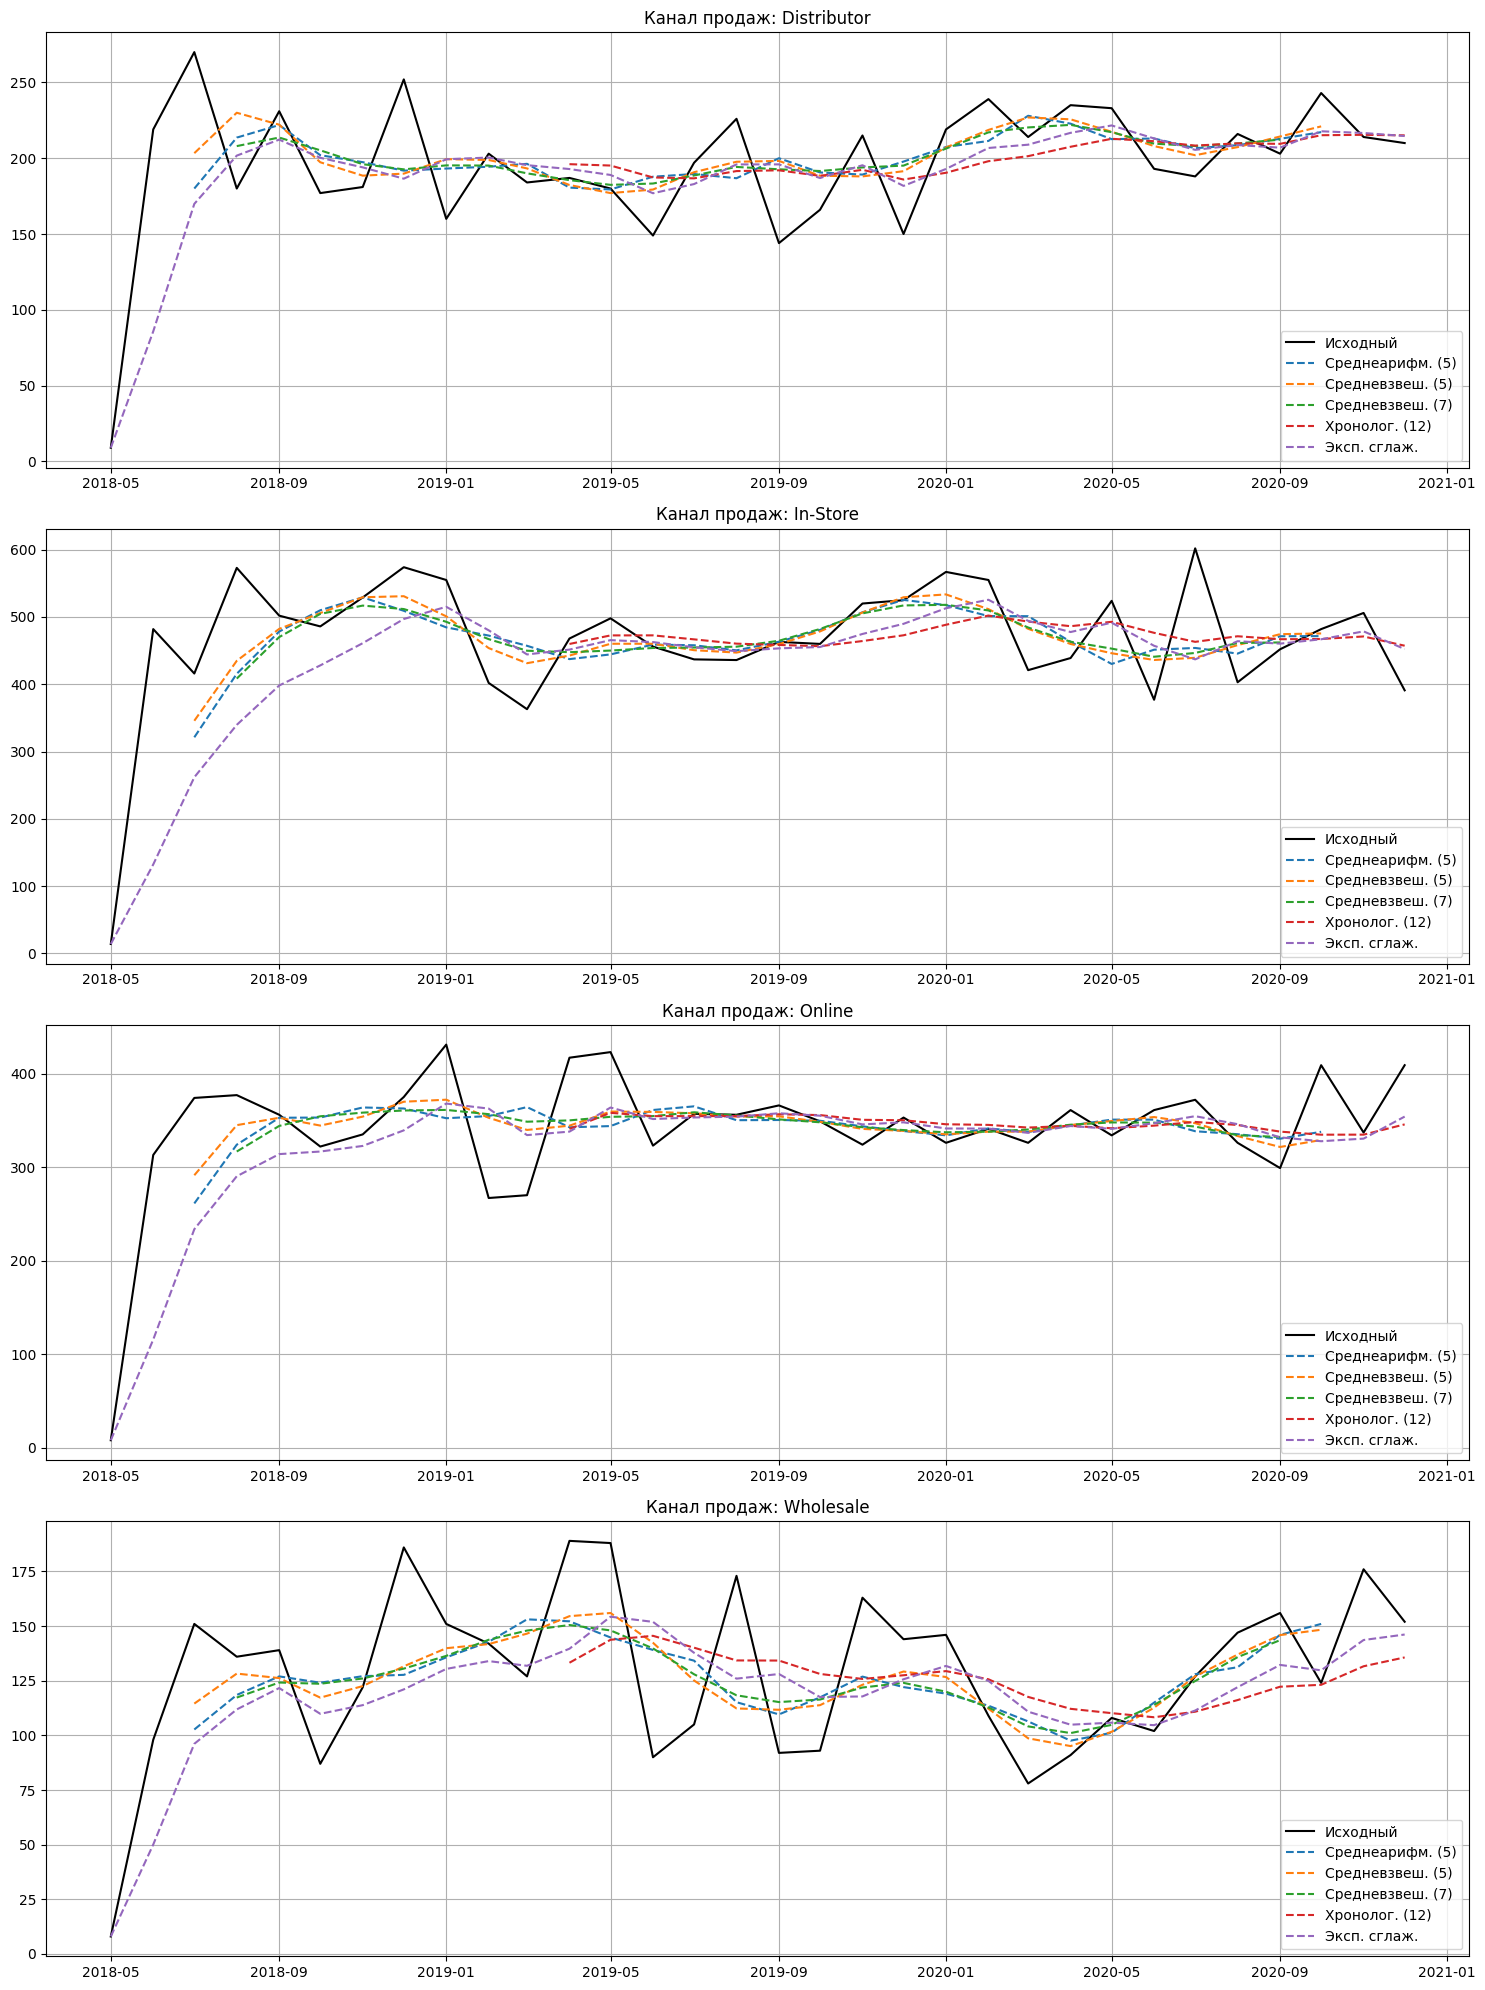

In [101]:
#Повторная агрегация по Sales Channel и месяцу (в случае потери переменной)
channel_monthly_series = df.groupby([df['OrderDate'].dt.to_period('M'), 'Sales Channel'])['Order Quantity'].sum().unstack()
channel_monthly_series.index = channel_monthly_series.index.to_timestamp()

# Повтор лабораторной работы 1 с учетом всех каналов
results = {}

for channel in channel_monthly_series.columns:
    series = channel_monthly_series[channel].copy().fillna(0)

    # Критерий Ирвина
    diffs = np.abs(series - series.shift(1))
    std = series.std()
    z_scores = diffs / std
    anomalies = z_scores > 1.5

    cleaned = series.copy()
    cleaned[anomalies] = (series.shift(1) + series.shift(-1)) / 2

    # Сглаживания
    rolling_5 = cleaned.rolling(5, center=True).mean()
    weights_5 = np.array([1, 2, 3, 2, 1]) / 9
    weighted_5 = cleaned.rolling(5, center=True).apply(lambda x: np.dot(x, weights_5), raw=True)

    weights_7 = np.array([1, 2, 3, 4, 3, 2, 1]) / 16
    weighted_7 = cleaned.rolling(7, center=True).apply(lambda x: np.dot(x, weights_7), raw=True)

    weights_12 = np.arange(1, 13)
    chronological_12 = cleaned.rolling(12).apply(lambda x: np.dot(x, weights_12) / weights_12.sum(), raw=True)

    exp_smooth = cleaned.ewm(alpha=0.3).mean()

    results[channel] = {
        'original': series,
        'cleaned': cleaned,
        'rolling_5': rolling_5,
        'weighted_5': weighted_5,
        'weighted_7': weighted_7,
        'chronological_12': chronological_12,
        'exp_smooth': exp_smooth
    }

# Построение графиков
fig, axes = plt.subplots(nrows=len(results), figsize=(15, 5 * len(results)))

if len(results) == 1:
    axes = [axes]

for ax, (channel, data) in zip(axes, results.items()):
    ax.plot(data['original'], label='Исходный', color='black')
    ax.plot(data['rolling_5'], label='Среднеарифм. (5)', linestyle='--')
    ax.plot(data['weighted_5'], label='Средневзвеш. (5)', linestyle='--')
    ax.plot(data['weighted_7'], label='Средневзвеш. (7)', linestyle='--')
    ax.plot(data['chronological_12'], label='Хронолог. (12)', linestyle='--')
    ax.plot(data['exp_smooth'], label='Эксп. сглаж.', linestyle='--')
    ax.set_title(f"Канал продаж: {channel}")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

# 2 . Обнаружение тренда

In [102]:
def check_trend_differences(series):
    n = len(series)
    first_half = series.iloc[:n//2]
    second_half = series.iloc[n//2:]
    mean_first = first_half.mean()
    mean_second = second_half.mean()
    delta = mean_second - mean_first
    print(f"Среднее первой половины: {mean_first:.2f}")
    print(f"Среднее второй половины: {mean_second:.2f}")
    print(f"Разность: {delta:.2f}")
    # разность между средними больше чем "условно допустимая случайная флуктуация",
    if np.abs(delta) > series.std() * 0.5:
        print(" Обнаружен тренд (по разности средних уровней)")
    else:
        print(" Тренд не обнаружен (по разности средних уровней)")

def foster_stewart_test(series):
    """
    Это эвристический метод, проще по сути, но мощный для монотонных трендов (линейных и экспоненциальных).
    (анализ новых максимумов/минимумов)
    """
    P = M = 0
    for i in range(1, len(series)):
        prev_values = series[:i]
        current = series[i]
        if current > prev_values.max():
            P += 1
        elif current < prev_values.min():
            M += 1
    print(f"P (повышений): {P}, M (понижений): {M}")
    d = np.abs(P - M)
    print(f"Разность |P - M| = {d}")
    # Простая интерпретация: если d > sqrt(n), то возможен тренд
    if d > np.sqrt(len(series)):
        print(" Обнаружен тренд (по методу Фостера-Стьюарта)")
    else:
        print(" Тренд не обнаружен (по методу Фостера-Стьюарта)")

def foster_stuart_variant1(series):
    """
    Это статистическая проверка случайности направления, применимая к рядам с шумом — хорошо подходит для выявления нелинейных трендов и цикличности.
    Анализ смены направления (знаков приращений)
    """
    diffs = np.diff(series)
    signs = np.sign(diffs)

    # Подсчёт смен знаков
    U = np.sum(signs[1:] != signs[:-1])
    S = np.sum(signs != 0)

    if S < 2:
        print("Недостаточно ненулевых приращений для оценки.")
        return

    # Теоретическое мат. ожидание и дисперсия
    E_U = (2 * S - 1) / 3
    sigma_U = np.sqrt((16 * S - 29) / 90)
    Z = (U - E_U) / sigma_U

    # Вывод результатов
    print(f" Метод Фостера-Стьюарта (анализ смен знаков):")
    print(f"  Кол-во смен знаков: U = {U}")
    print(f"  Кол-во ненулевых приращений: S = {S}")
    print(f"  Ожидаемое значение E[U] = {E_U:.2f}")
    print(f"  Ст. отклонение σ[U] = {sigma_U:.2f}")
    print(f"  Z-статистика = {Z:.3f}")

    # Интерпретация
    alpha = 1.96  # критическое значение для 95%
    if np.abs(Z) > alpha:
        print(" Тренд обнаружен (Z выходит за пределы доверительного интервала)")
    else:
        print(" Тренд не обнаружен (Z в пределах доверительного интервала)")

In [103]:
unique_sales = df['Sales Channel'].unique()

for name in unique_sales:
    # Подготовка временного ряда
    print(f"NAME {name}")
    series = channel_monthly_series[name].fillna(0)

    # Применение методов
    print("🔹 Метод разности средних уровней:")
    check_trend_differences(series)

    print("🔹 Метод Фостера-Стьюарта:")
    foster_stewart_test(series)

    print("🔹 Метод Фостера-Стьюарта:")
    foster_stuart_variant1(series)
    print("\n")

NAME In-Store
🔹 Метод разности средних уровней:
Среднее первой половины: 449.44
Среднее второй половины: 480.44
Разность: 31.00
 Тренд не обнаружен (по разности средних уровней)
🔹 Метод Фостера-Стьюарта:
P (повышений): 4, M (понижений): 0
Разность |P - M| = 4
 Тренд не обнаружен (по методу Фостера-Стьюарта)
🔹 Метод Фостера-Стьюарта:
 Метод Фостера-Стьюарта (анализ смен знаков):
  Кол-во смен знаков: U = 17
  Кол-во ненулевых приращений: S = 31
  Ожидаемое значение E[U] = 20.33
  Ст. отклонение σ[U] = 2.28
  Z-статистика = -1.463
 Тренд не обнаружен (Z в пределах доверительного интервала)


NAME Online
🔹 Метод разности средних уровней:
Среднее первой половины: 331.50
Среднее второй половины: 349.56
Разность: 18.06
 Тренд не обнаружен (по разности средних уровней)
🔹 Метод Фостера-Стьюарта:
P (повышений): 4, M (понижений): 0
Разность |P - M| = 4
 Тренд не обнаружен (по методу Фостера-Стьюарта)
🔹 Метод Фостера-Стьюарта:
 Метод Фостера-Стьюарта (анализ смен знаков):
  Кол-во смен знаков: U 

In [104]:
series = pd.Series([100, 102, 105, 107, 110, 112, 115, 117])
check_trend_differences(series)
series.std()

Среднее первой половины: 103.50
Среднее второй половины: 113.50
Разность: 10.00
 Обнаружен тренд (по разности средних уровней)


6.07100838882165

## Лабораторная работа 3 ВЫДЕЛЕНИЕ КОМПОНЕНТ ТРЕНД-СЕЗОННОГО

```
Для выполнения задания по выделению компонентов временного ряда Yt— тренда Ut-сезонной компоненты Vt и остатка εt 
аддитивная модель: Yt = Ut + Vt + εt
```

In [105]:
# Аггрегируем по месяцам и каналам
monthly = df.groupby([df['OrderDate'].dt.to_period('M'), 'Sales Channel'])['Order Quantity'].sum().unstack()
monthly.index = monthly.index.to_timestamp()
monthly = monthly.fillna(0)

results = {}

for channel in monthly.columns:
    Yt = monthly[channel]
    
    # Предварительный тренд: скользящее среднее
    trend_rough = Yt.rolling(12, center=True).mean()
    
    # Остатки (для сезонности)
    detrended = Yt - trend_rough
    
    # 1-я сезонная компонента
    seasonal_wave = detrended.groupby(detrended.index.month).mean()
    seasonal = Yt.index.month.map(seasonal_wave.to_dict())
    seasonal = pd.Series(seasonal, index=Yt.index)
    
    # 2-й тренд: Yt - сезонность → сглаживание
    Y_minus_seasonal = Yt - seasonal
    trend_refined = Y_minus_seasonal.rolling(12, center=True).mean()
    
    # Остаточная компонента
    residual = Yt - trend_refined - seasonal

    results[channel] = {
        'original': Yt,
        'trend_rough': trend_rough,
        'seasonal': seasonal,
        'trend_refined': trend_refined,
        'residual': residual,
        'seasonal_wave': seasonal_wave
    }

monthly

Sales Channel,Distributor,In-Store,Online,Wholesale
OrderDate,,,,
2018-05-01,9,14,8,8
2018-06-01,219,482,313,98
2018-07-01,270,416,374,151
2018-08-01,180,573,377,136
2018-09-01,231,502,356,139
2018-10-01,177,486,322,87
2018-11-01,181,529,335,122
2018-12-01,252,574,375,186
2019-01-01,160,555,431,151


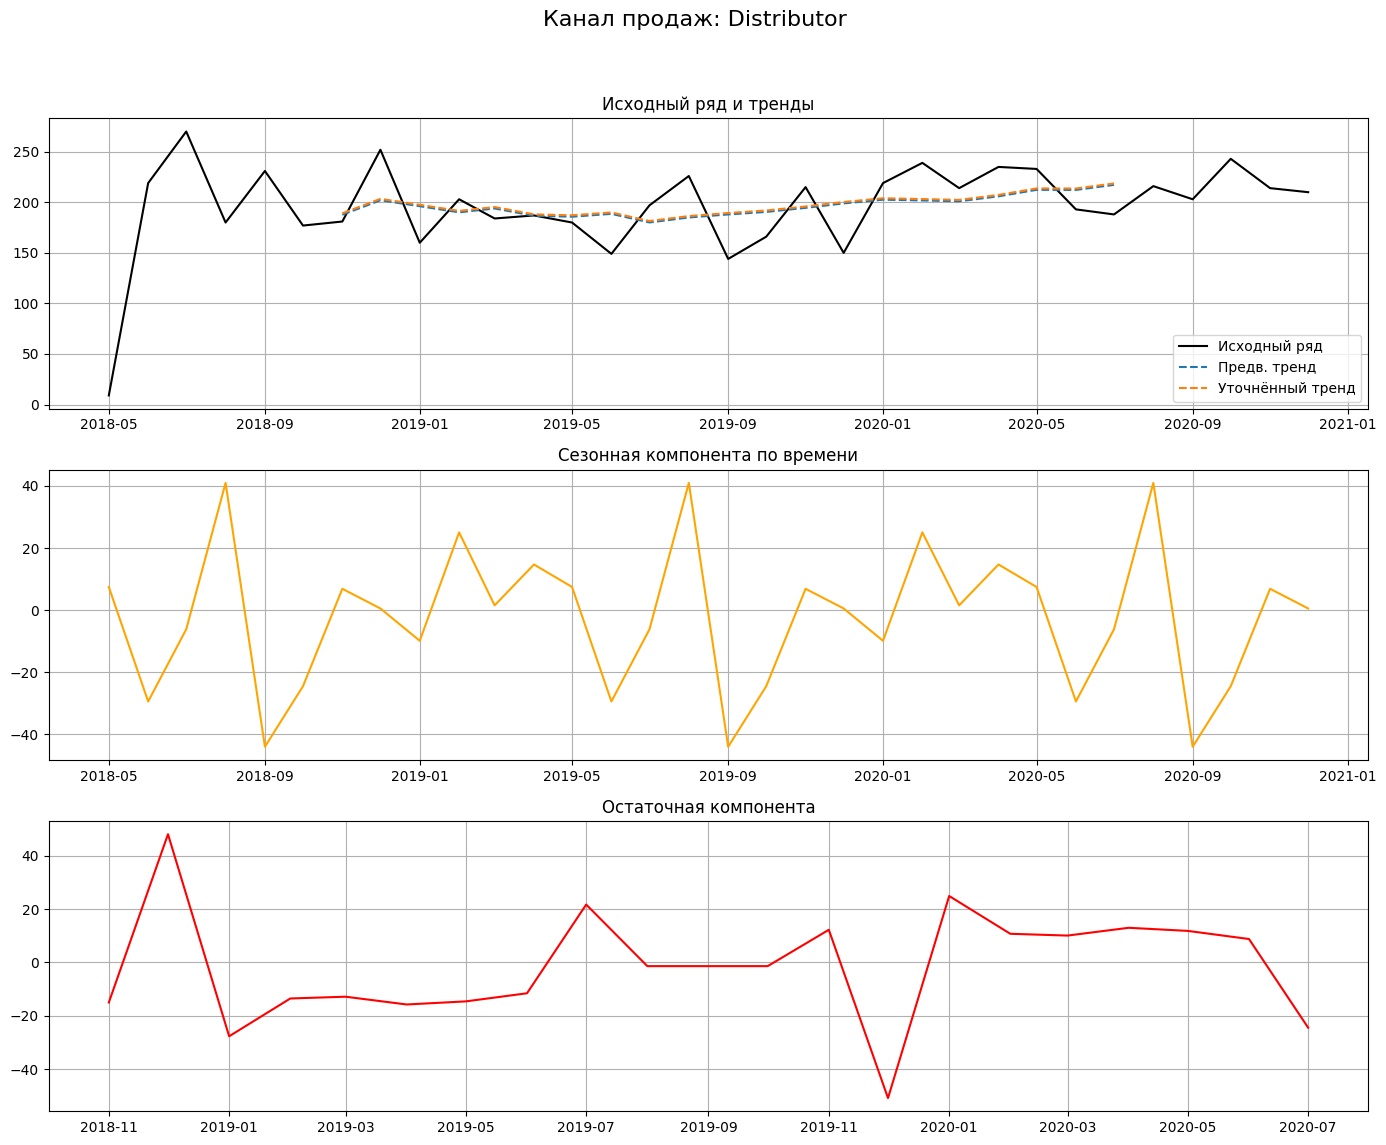

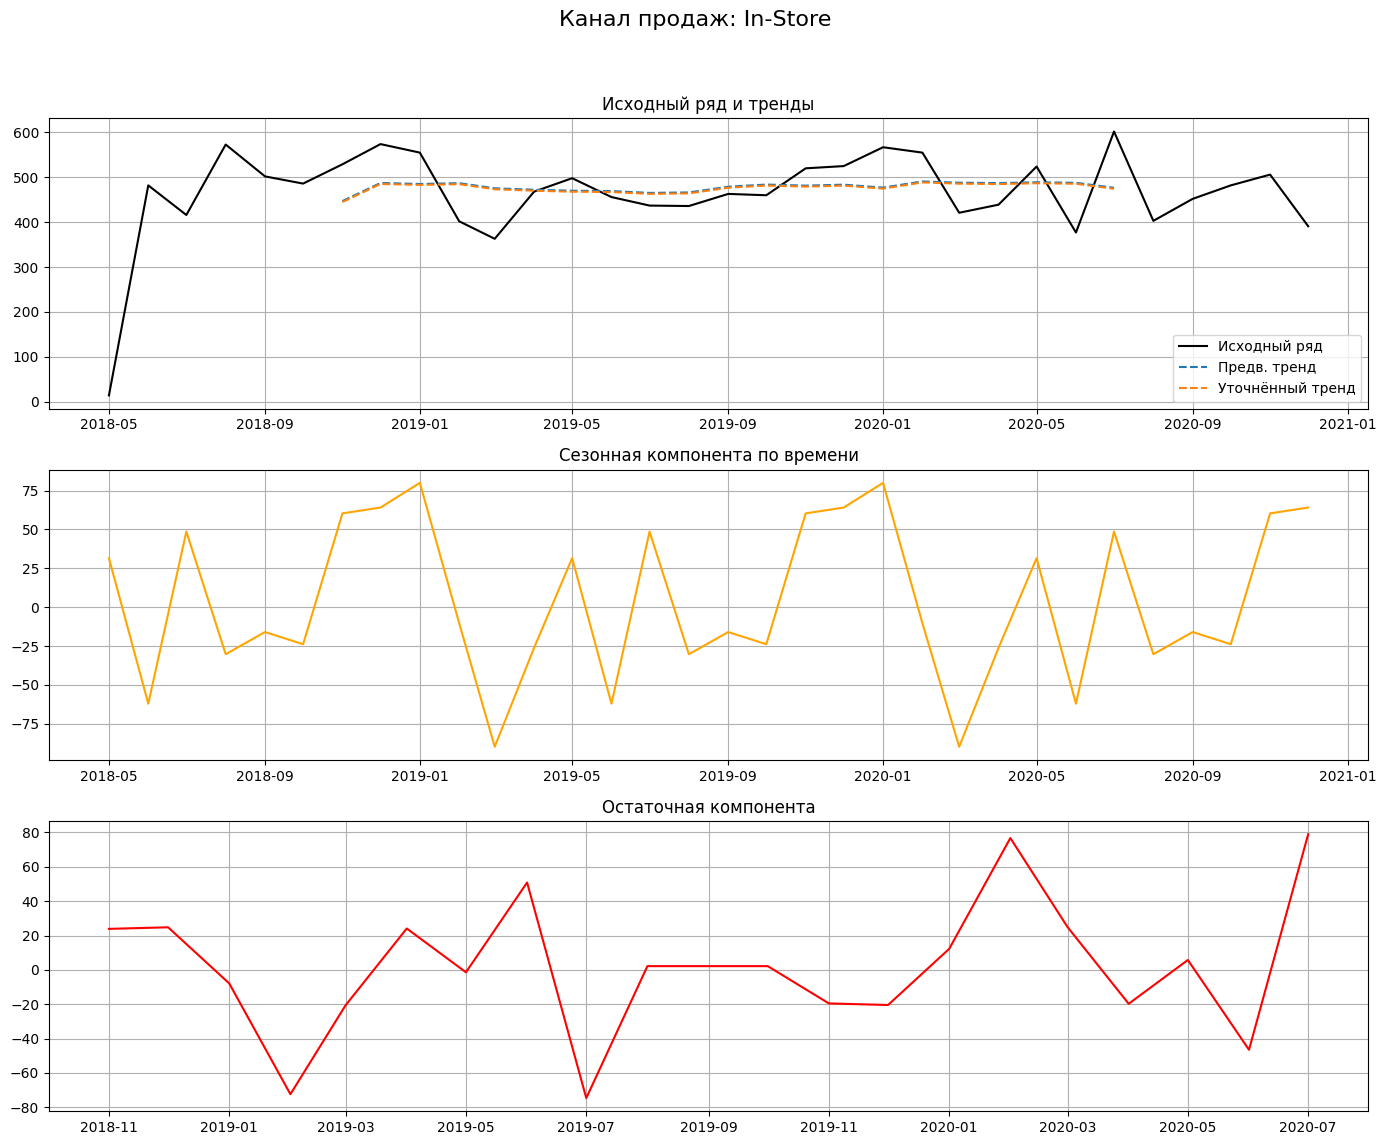

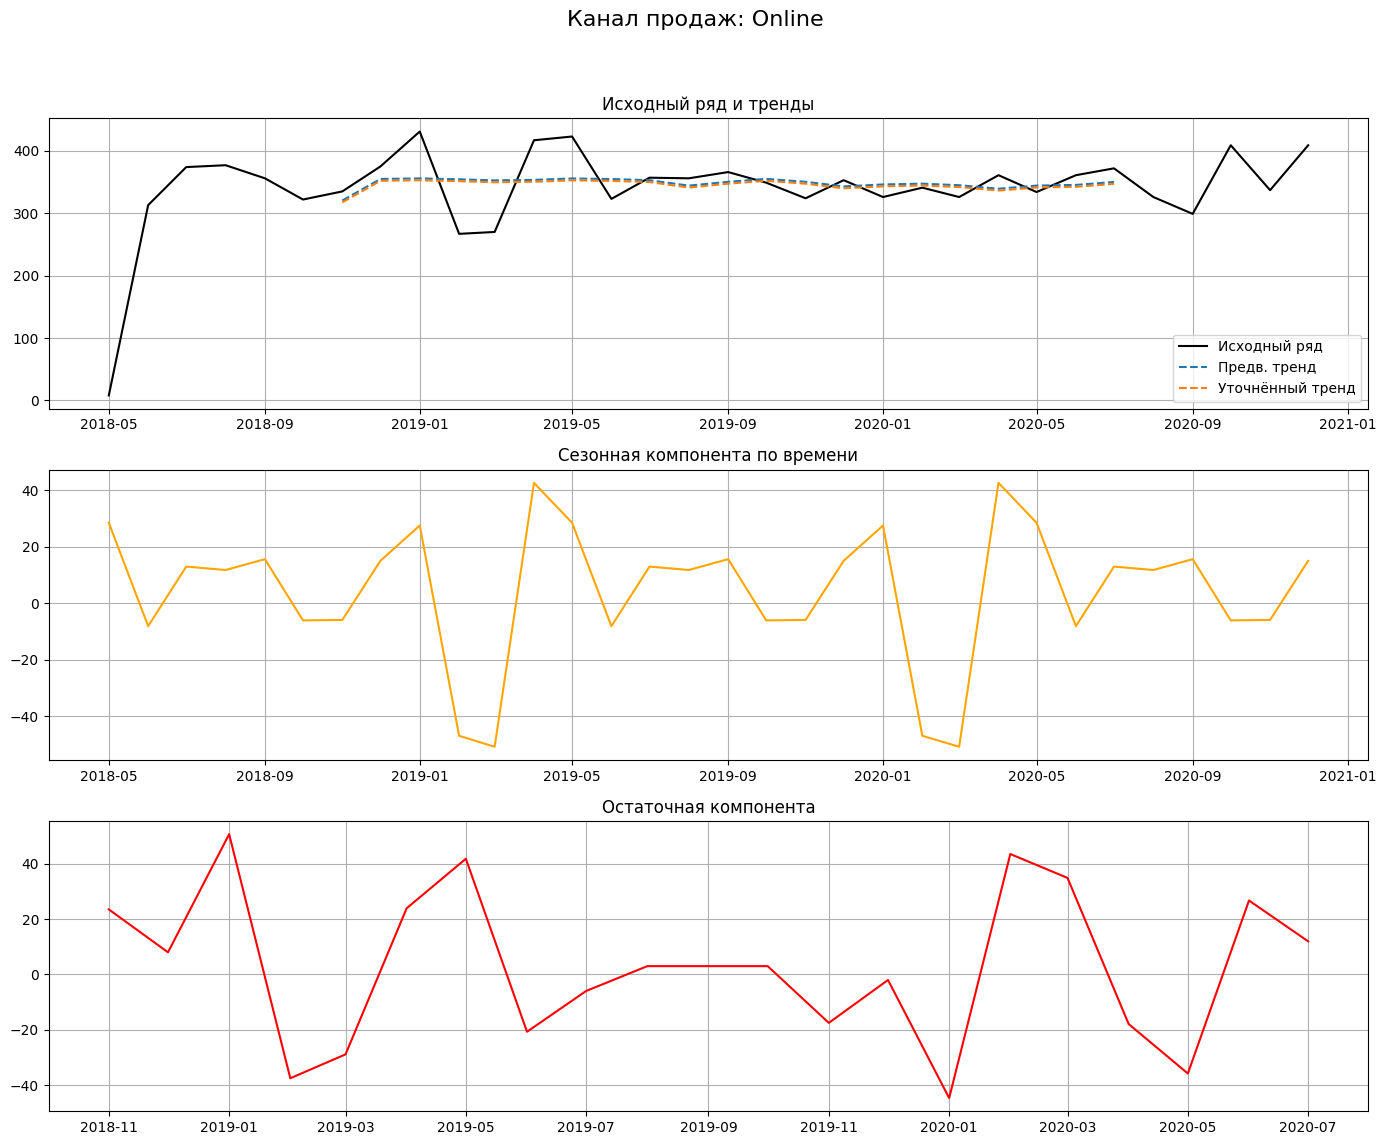

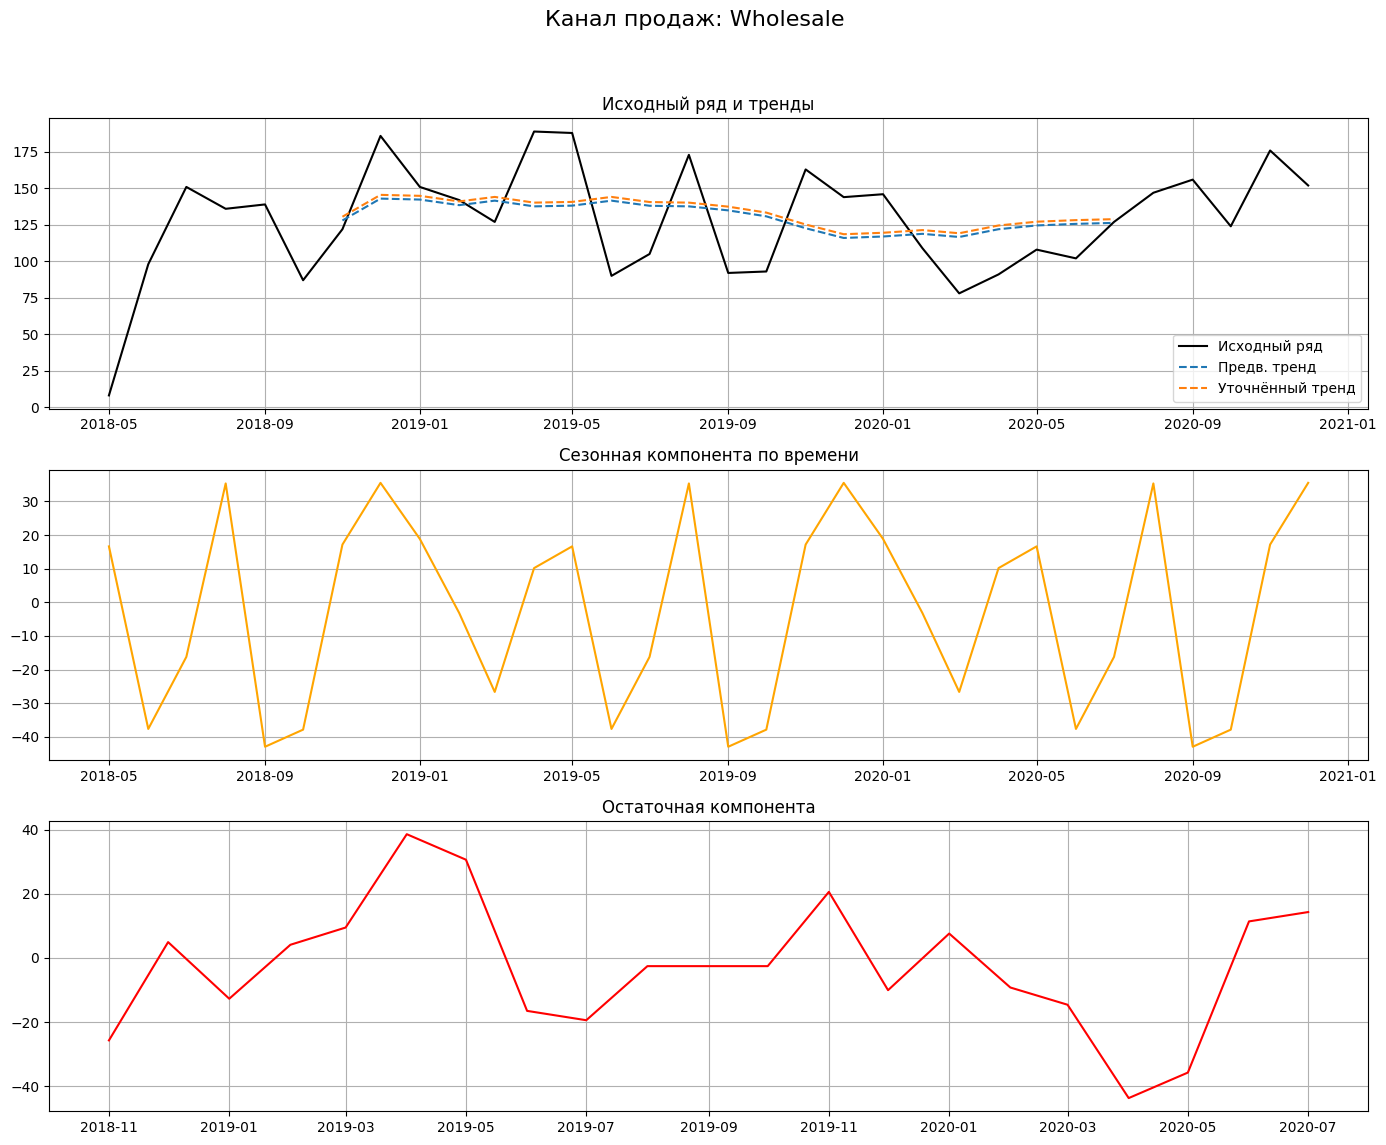

In [106]:
figs = []
for channel, data in results.items():
    fig, axs = plt.subplots(3, 1, figsize=(14, 12))
    fig.suptitle(f'Канал продаж: {channel}', fontsize=16)

    axs[0].plot(data['original'], label='Исходный ряд', color='black')
    axs[0].plot(data['trend_rough'], label='Предв. тренд', linestyle='--')
    axs[0].plot(data['trend_refined'], label='Уточнённый тренд', linestyle='--')
    axs[0].legend()
    axs[0].set_title("Исходный ряд и тренды")
    axs[0].grid(True)

    axs[1].plot(data['seasonal'], label='Сезонная компонента', color='orange')
    axs[1].set_title("Сезонная компонента по времени")
    axs[1].grid(True)

    axs[2].plot(data['residual'], label='Остаточная компонента', color='red')
    axs[2].set_title("Остаточная компонента")
    axs[2].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    figs.append(fig)

plt.show()

# 4 — выбор кривой роста и определению её параметров.

In [107]:
# Подготовка словаря для хранения параметров и моделей
growth_models = {}

# Временная шкала
t_values = np.arange(len(monthly))

# monthly = monthly.iloc[1:]

# # Временная шкала
# t_values = np.arange(1, len(monthly)+1)

for channel in monthly.columns:
    Y = monthly[channel].values

    print(Y)

    # Сглаживание по 3 точкам (центрированное)
    Y_smooth = pd.Series(Y).rolling(3, center=True).mean().to_numpy()

    # Исключаем NaN из сглаженного ряда и подгоняем t
    mask = ~np.isnan(Y_smooth)
    t_valid = t_values[mask]
    Y_valid = Y_smooth[mask]

    # Линейная модель: y = a + bt
    coeffs_linear = np.polyfit(t_valid, Y_valid, 1)
    linear_model = np.poly1d(coeffs_linear)

    # Экспоненциальная модель: y = a * exp(bt)
    def exp_func(t, a, b):
        return a * np.exp(b * t)

    try:
        popt, _ = curve_fit(exp_func, t_valid, Y_valid, maxfev=10000)
        exp_model = lambda t: exp_func(t, *popt)
    except RuntimeError:
        exp_model = None

    growth_models[channel] = {
        't': t_valid,
        'Y': Y, 
        'Y_smooth': Y_valid,
        'linear_model': linear_model,
        'exp_model': exp_model,
        'coeffs_linear': coeffs_linear,
        'coeffs_exp': popt if exp_model else None
    }

[  9 219 270 180 231 177 181 252 160 203 184 187 180 149 197 226 144 166
 215 150 219 239 214 235 233 193 188 216 203 243 214 210]
[ 14 482 416 573 502 486 529 574 555 402 363 468 498 456 437 436 463 460
 520 525 567 555 421 439 524 377 602 403 452 482 506 391]
[  8 313 374 377 356 322 335 375 431 267 270 417 423 323 357 356 366 349
 324 353 326 341 326 361 334 361 372 326 299 409 337 409]
[  8  98 151 136 139  87 122 186 151 142 127 189 188  90 105 173  92  93
 163 144 146 109  78  91 108 102 127 147 156 124 176 152]


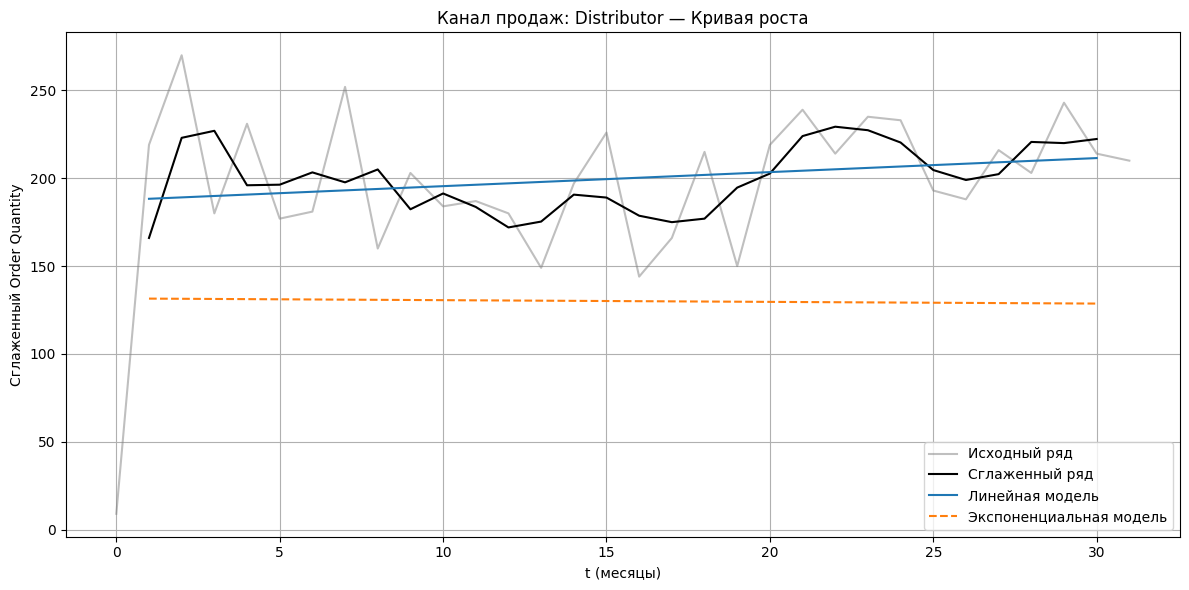

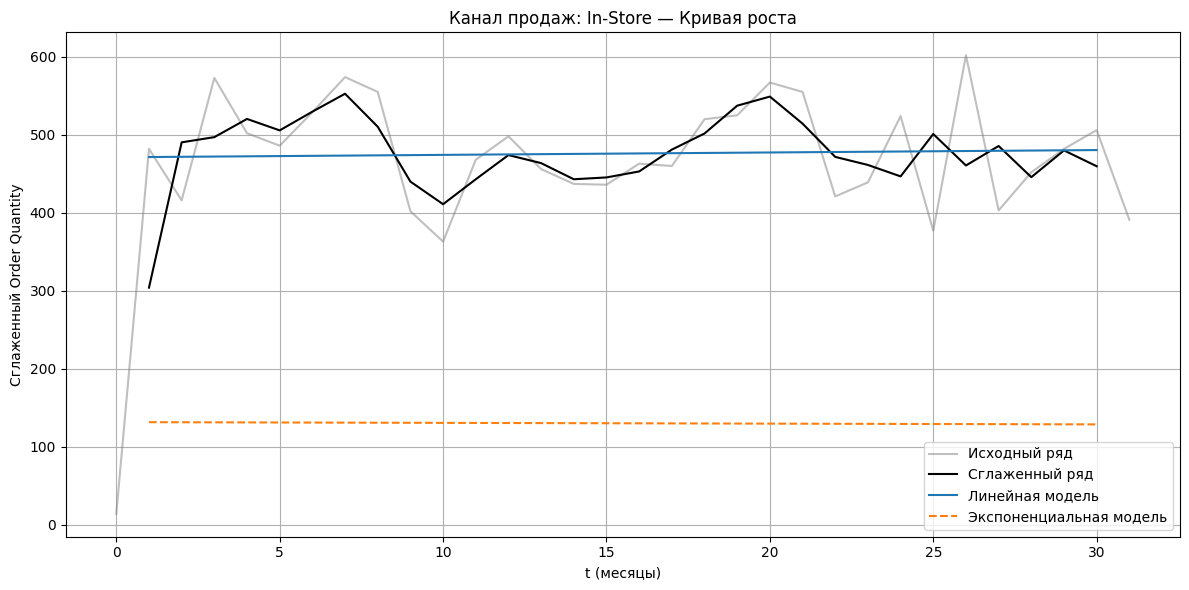

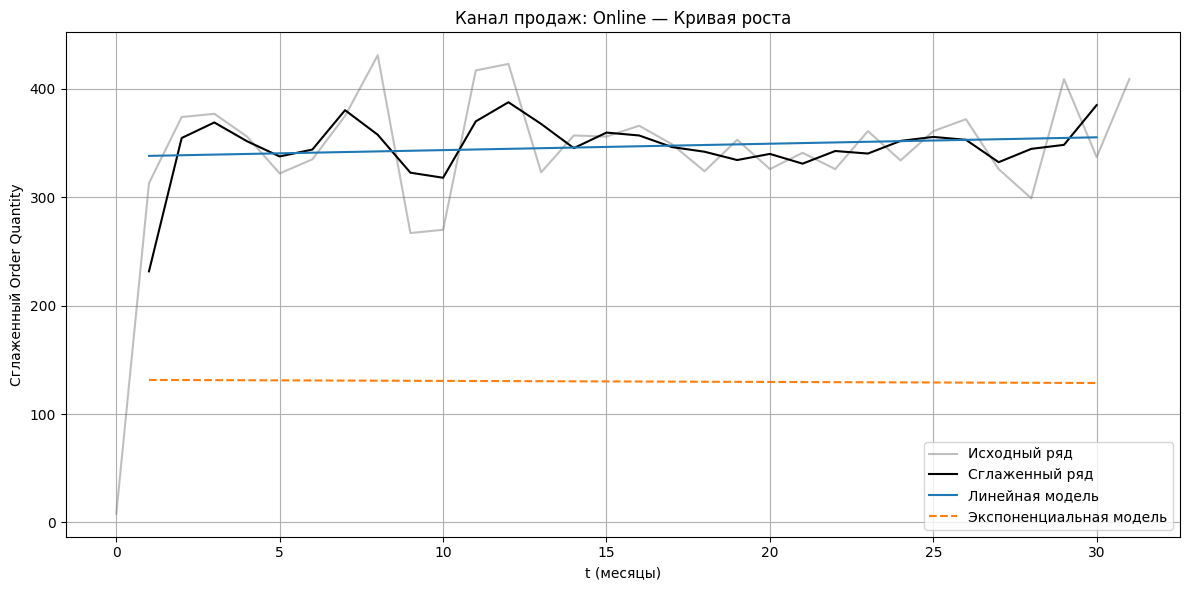

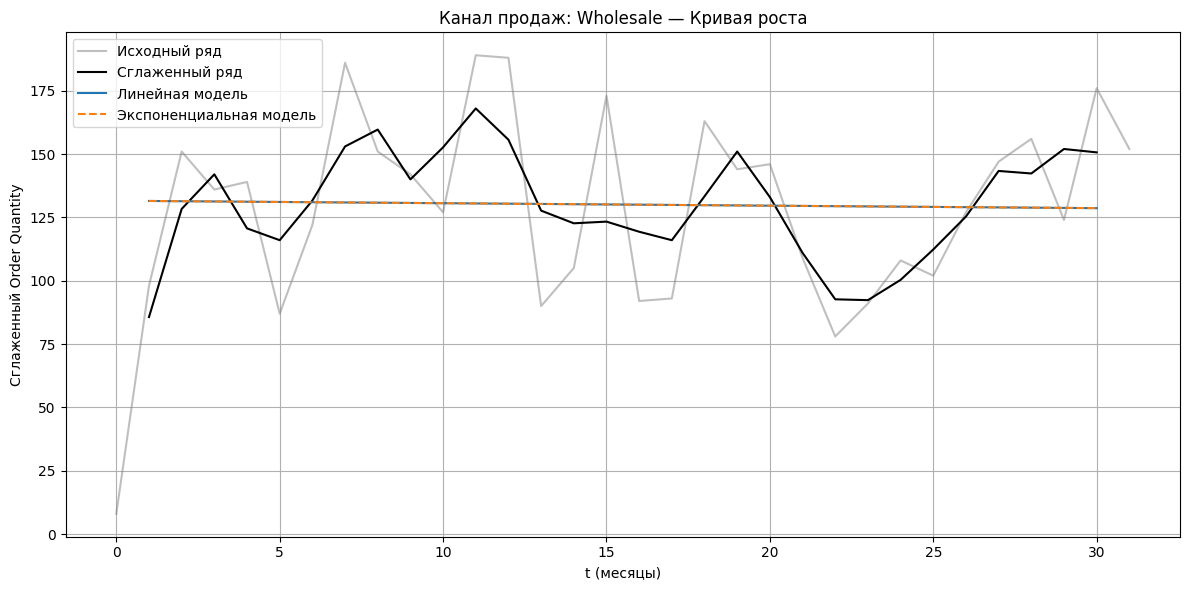

In [ ]:
figs = []
for channel, data in growth_models.items():
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(t_values, monthly[channel].values, label='Исходный ряд', color='gray', alpha=0.5)
    ax.plot(data['t'], data['Y_smooth'], label='Сглаженный ряд', color='black')
    ax.plot(data['t'], data['linear_model'](data['t']), label='Линейная модель', linestyle='-')
    if data['exp_model']:
        ax.plot(data['t'], data['exp_model'](data['t']), label='Экспоненциальная модель', linestyle='--')
    ax.set_title(f'Канал продаж: {channel} — Кривая роста')
    ax.set_xlabel("t (месяцы)")
    ax.set_ylabel("Сглаженный Order Quantity")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    figs.append(fig)

plt.show()

In [120]:
df.head()

,OrderNumber,Sales Channel,WarehouseCode,ProcuredDate,OrderDate,ShipDate,DeliveryDate,CurrencyCode,_SalesTeamID,_CustomerID,_StoreID,_ProductID,Order Quantity,Discount Applied,Unit Cost,Unit Price
0,SO - 000101,In-Store,WARE-UHY1004,31/12/17,2018-05-31,14/6/18,19/6/18,USD,6,15,259,12,5,0.075,1001.18,1963.1
1,SO - 000102,Online,WARE-NMK1003,31/12/17,2018-05-31,22/6/18,2/7/18,USD,14,20,196,27,3,0.075,3348.66,3939.6
2,SO - 000103,Distributor,WARE-UHY1004,31/12/17,2018-05-31,21/6/18,1/7/18,USD,21,16,213,16,1,0.050,781.22,1775.5
3,SO - 000104,Wholesale,WARE-NMK1003,31/12/17,2018-05-31,2/6/18,7/6/18,USD,28,48,107,23,8,0.075,1464.69,2324.9
4,SO - 000105,Distributor,WARE-NMK1003,10/4/18,2018-05-31,16/6/18,26/6/18,USD,22,49,111,26,8,0.100,1476.14,1822.4


# Лабораторная работа 5 ОЦЕНКА АДЕКВАТНОСТИ ТРЕНДОВОЙ МОДЕЛИ

In [109]:
adequacy_results = {}

for channel in results:
    residual = results[channel]['residual'].dropna()

    # Критерий пиков
    peaks = sum((residual.shift(1) < residual) & (residual.shift(-1) < residual))

    # Критерий серий (чередования знаков)
    signs = np.sign(residual)
    runs = np.sum(signs[1:].values != signs[:-1].values) + 1

    # Асимметрия и эксцесс
    skewness = skew(residual)
    excess_kurt = kurtosis(residual)

    # Среднее значение = 0 ?
    t_stat, p_value = ttest_1samp(residual, 0)

    # Автокорреляция: критерий Дарбина-Уотсона
    dw_stat = durbin_watson(residual)

    # Сохраняем
    adequacy_results[channel] = {
        'Пики': peaks,
        'Серии': runs,
        'Асимметрия': round(skewness, 3),
        'Эксцесс': round(excess_kurt, 3),
        't-статистика': round(t_stat, 3),
        'p-значение (t)': round(p_value, 3),
        'Дарбин-Уотсон': round(dw_stat, 3)
    }

# Вывод
for channel, metrics in adequacy_results.items():
    print(f"\nКанал продаж: {channel}")
    for k, v in metrics.items():
        print(f"{k}: {v}")


Канал продаж: Distributor
Пики: 6
Серии: 9
Асимметрия: 0.0
Эксцесс: 0.398
t-статистика: -0.298
p-значение (t): 0.768
Дарбин-Уотсон: 2.458

Канал продаж: In-Store
Пики: 6
Серии: 13
Асимметрия: 0.0
Эксцесс: -0.005
t-статистика: 0.248
p-значение (t): 0.806
Дарбин-Уотсон: 2.017

Канал продаж: Online
Пики: 5
Серии: 9
Асимметрия: 0.0
Эксцесс: -1.037
t-статистика: 0.487
p-значение (t): 0.631
Дарбин-Уотсон: 2.159

Канал продаж: Wholesale
Пики: 4
Серии: 10
Асимметрия: -0.0
Эксцесс: -0.254
t-статистика: -0.576
p-значение (t): 0.571
Дарбин-Уотсон: 1.21


Критерии адекватности:
* Модель считается адекватной, если остатки:
* Случайны (нормальное распределение, чередование серий, умеренное число пиков);
* Имеют нулевое среднее (t-тест, p > 0.05);
* Не автокоррелированы (Дарбин-Уотсон ≈ 2);
* Не имеют существенной асимметрии и эксцесса (близко к 0).

Distributor
* Пики: в допустимых пределах.
* Серии: 9 — умеренно.
* Асимметрия: 0.0.
* Эксцесс: +0.398 (слегка более «острые» значения, но допустимо).
* t-тест: p = 0.768 — нет смещения.
* Дарбин-Уотсон: 2.458 — возможна лёгкая отрицательная автокорреляция, но в норме.
* Вывод: модель адекватна.

In-Store
* Пики:  6 — ок.
* Серии: 13 — отлично.
* Асимметрия / Эксцесс: почти 0.
* t-тест: p = 0.806.
* Дарбин-Уотсон: 2.017 — идеальное значение.
* Вывод: модель полностью адекватна.

Online
* Пики и серии: допустимо.
* Асимметрия: 0.0.
* Эксцесс: -1.037 — плоское распределение (меньше выбросов, допустимо).
* t-тест: p = 0.631.
* Дарбин-Уотсон: 2.159.
* Вывод: модель адекватна, несмотря на "плоские" остатки.

Wholesale
* Пики и серии:  допустимы.
* Асимметрия / эксцесс: .
* t-тест:  p = 0.571.
* Дарбин-Уотсон: 1.21 — сильная положительная автокорреляция остатков.
* Вывод: модель не полностью адекватна — присутствует автокорреляция в остатках. Следует уточнить модель (например, добавить лаг или использовать ARIMA).

##### Модели для Distributor, In-Store и Online можно признать адекватными.

# Лабораторная работа 6 ПРОГНОЗИРОВАНИЕ НА ОСНОВЕ ТРЕНДОВОЙ МОДЕЛИ

In [ ]:
from pprint import pprint
# Выбор каналов с адекватными моделями
selected_channels = ['Online', 'In-Store', 'Distributor']

# Прогноз на 3 и 7 шагов
forecast_results = {}

for channel in selected_channels:
    Y = monthly[channel].values
    t_values = np.arange(len(Y))

    # Сглаживание по 3 точкам (центрированное)
    Y_smooth = pd.Series(Y).rolling(3, center=True).mean().dropna()
    t_smooth = np.arange(len(Y))[1:-1]

    # Линейная модель
    coeffs_linear = np.polyfit(t_smooth, Y_smooth, 1)
    linear_model = np.poly1d(coeffs_linear)

    # Экспоненциальная модель
    def exp_func(t, a, b):
        return a * np.exp(b * t)

    try:
        popt, _ = curve_fit(exp_func, t_smooth, Y_smooth, maxfev=10000)
        exp_model = lambda t: exp_func(t, *popt)
    except RuntimeError:
        exp_model = None

    future_steps = [3, 7]
    forecast_data = {
        'linear': {step: linear_model(len(Y) + step) for step in future_steps},
        'exp': {step: exp_model(len(Y) + step) if exp_model else None for step in future_steps},
        'linear_interval': {},
        'exp_interval': {},
    }

    # Интервалы доверия (приблизительно, ±1.96 * std остатков)
    residuals_linear = Y_smooth - linear_model(t_smooth)
    std_linear = np.std(residuals_linear)
    for step in future_steps:
        forecast_data['linear_interval'][step] = (
            forecast_data['linear'][step] - 1.96 * std_linear,
            forecast_data['linear'][step] + 1.96 * std_linear
        )

    if exp_model:
        residuals_exp = Y_smooth - exp_model(t_smooth)
        std_exp = np.std(residuals_exp)
        for step in future_steps:
            forecast_data['exp_interval'][step] = (
                forecast_data['exp'][step] - 1.96 * std_exp,
                forecast_data['exp'][step] + 1.96 * std_exp
            )

    forecast_results[channel] = forecast_data

pprint(forecast_results)

[  8 313 374 377 356 322 335 375 431 267 270 417 423 323 357 356 366 349
 324 353 326 341 326 361 334 361 372 326 299 409 337 409]
[ 14 482 416 573 502 486 529 574 555 402 363 468 498 456 437 436 463 460
 520 525 567 555 421 439 524 377 602 403 452 482 506 391]
[  9 219 270 180 231 177 181 252 160 203 184 187 180 149 197 226 144 166
 215 150 219 239 214 235 233 193 188 216 203 243 214 210]
{'Distributor': {'exp': {3: 216.5731294811484, 7: 220.19408234332388},
                 'exp_interval': {3: (182.91570886881013, 250.2305500934867),
                                  7: (186.5366617309856, 253.85150295566217)},
                 'linear': {3: 215.47442837720948, 7: 218.67146211840344},
                 'linear_interval': {3: (181.71682390197378,
                                         249.23203285244517),
                                     7: (184.91385764316774,
                                         252.42906659363913)}},
 'In-Store': {'exp': {3: 481.89431088827524, 7: 483.1231

Разброс интервалов подтверждает стабильность моделей, особенно у канала Online, где линейная и экспоненциальная модели практически совпадают.

Канал Distributor показывает небольшой, но устойчивый рост.

У In-Store — прогноз стабильно выше, но с шире интервалами → возможны внешние факторы.



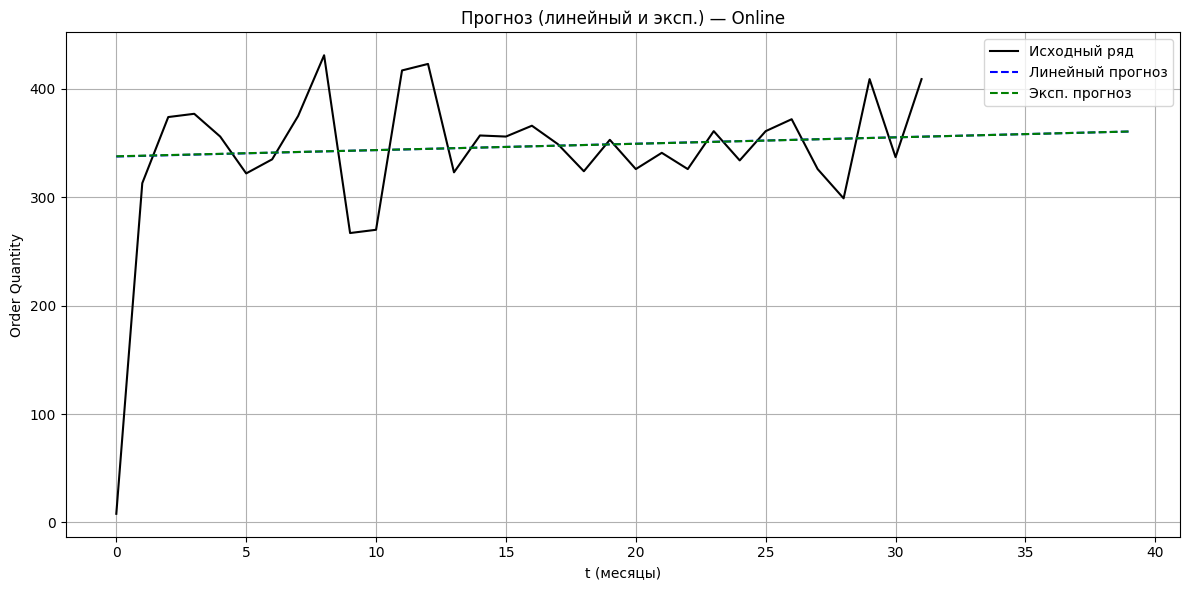

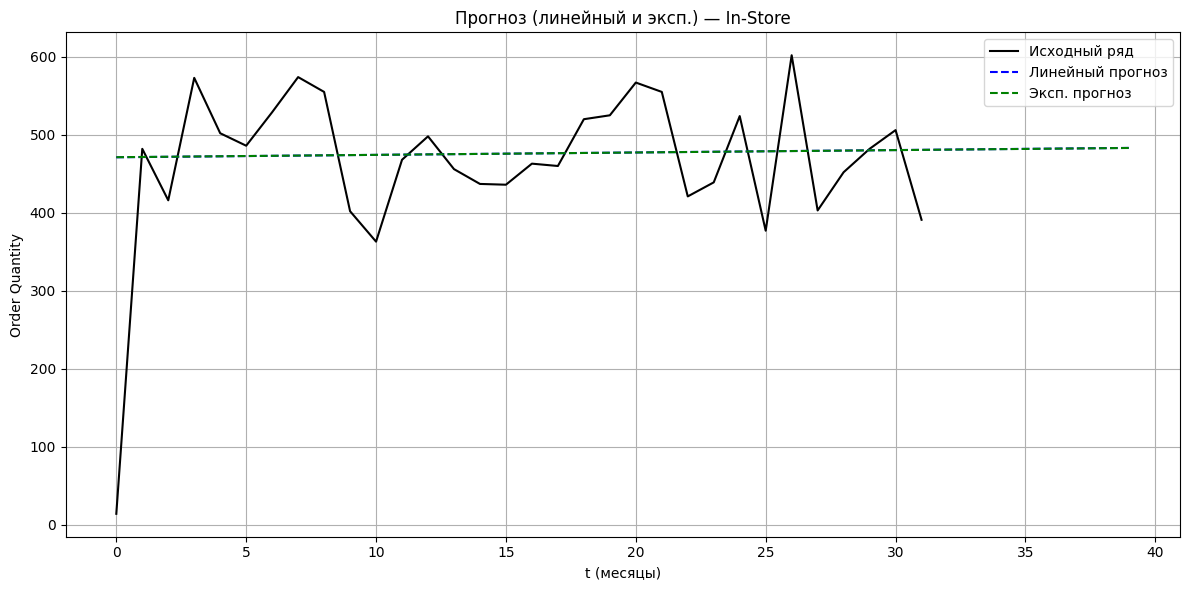

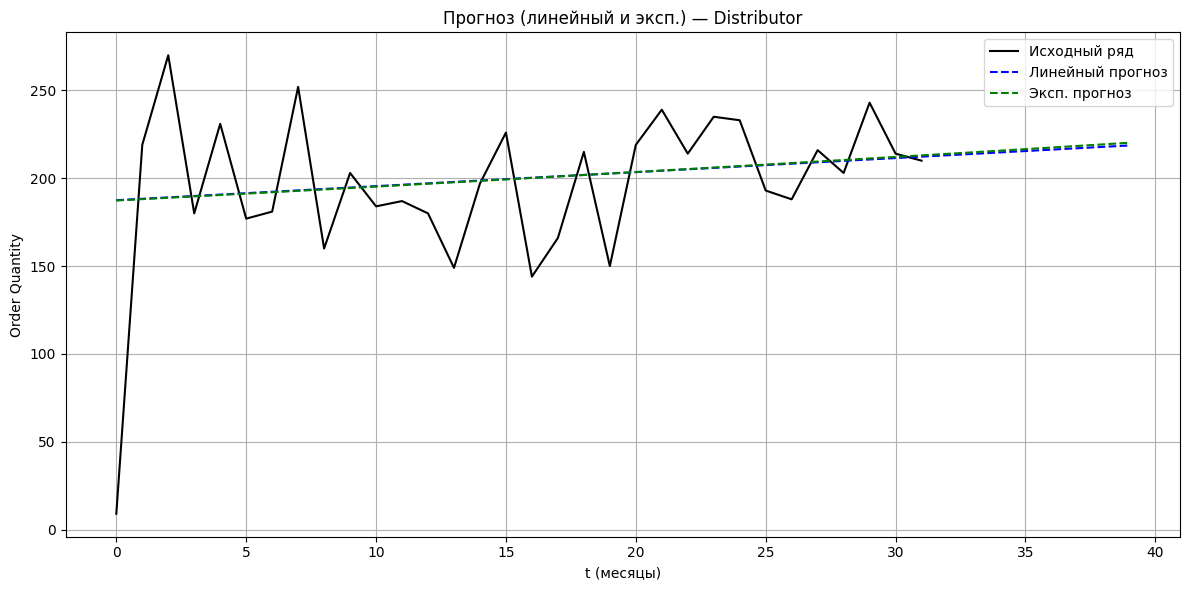

In [111]:
figs = []
for channel in selected_channels:
    Y = monthly[channel].values
    t = np.arange(len(Y))
    future_t = np.arange(len(Y) + 8)

    # Модели
    linear_model = np.poly1d(np.polyfit(t[1:-1], pd.Series(Y).rolling(3, center=True).mean().dropna(), 1))
    exp_params = forecast_results[channel]['exp'][3]  # Проверка на существование
    exp_model = None
    try:
        popt, _ = curve_fit(lambda t, a, b: a * np.exp(b * t), t[1:-1], pd.Series(Y).rolling(3, center=True).mean().dropna(), maxfev=10000)
        exp_model = lambda x: popt[0] * np.exp(popt[1] * x)
    except:
        pass

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(t, Y, label="Исходный ряд", color="black")
    ax.plot(future_t, linear_model(future_t), label="Линейный прогноз", linestyle="--", color="blue")
    if exp_model:
        ax.plot(future_t, exp_model(future_t), label="Эксп. прогноз", linestyle="--", color="green")
    
    ax.set_title(f"Прогноз (линейный и эксп.) — {channel}")
    ax.set_xlabel("t (месяцы)")
    ax.set_ylabel("Order Quantity")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    figs.append(fig)

plt.show()

У Online и Distributor — наблюдается устойчивый рост, хорошо описываемый обеими моделями.

У In-Store — также заметен рост, но разброс данных чуть шире, что отражено в прогнозе.

# 7

In [112]:
def brown_forecast(series, alpha=0.3, forecast_steps=7, stop_at=None):
    if stop_at is None:
        stop_at = len(series)

    S1 = [series[1]]
    S2 = [series[1]]

    for t in range(1, stop_at):
        S1.append(alpha * series[t] + (1 - alpha) * S1[-1])
        S2.append(alpha * S1[-1] + (1 - alpha) * S2[-1])

    S1 = np.array(S1)
    S2 = np.array(S2)

    a_t = 2 * S1[-1] - S2[-1]
    b_t = (alpha / (1 - alpha)) * (S1[-1] - S2[-1])

    fitted = a_t + b_t * np.arange(len(series))
    forecast = [a_t + b_t * k for k in range(1, forecast_steps + 1)]

    # Оценка ошибки модели (на обучающем куске)
    residuals = series[:stop_at] - (2 * S1 - S2)
    std = np.std(residuals)
    ci = 1.96 * std

    return fitted, forecast, ci

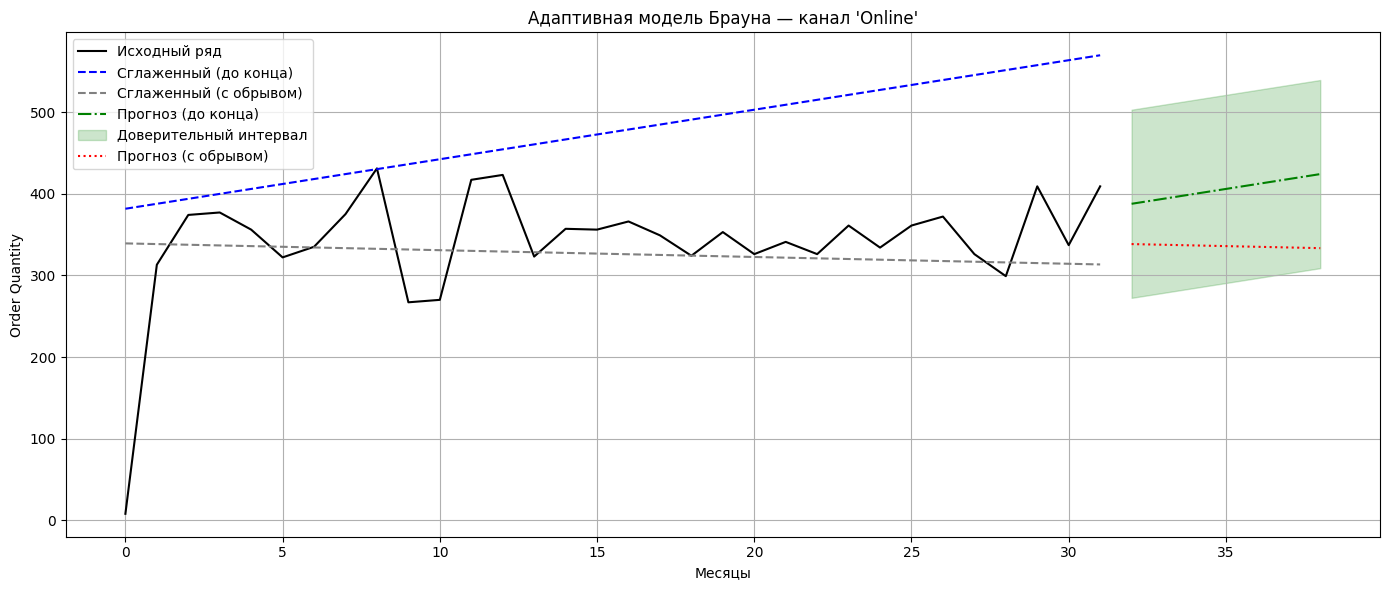

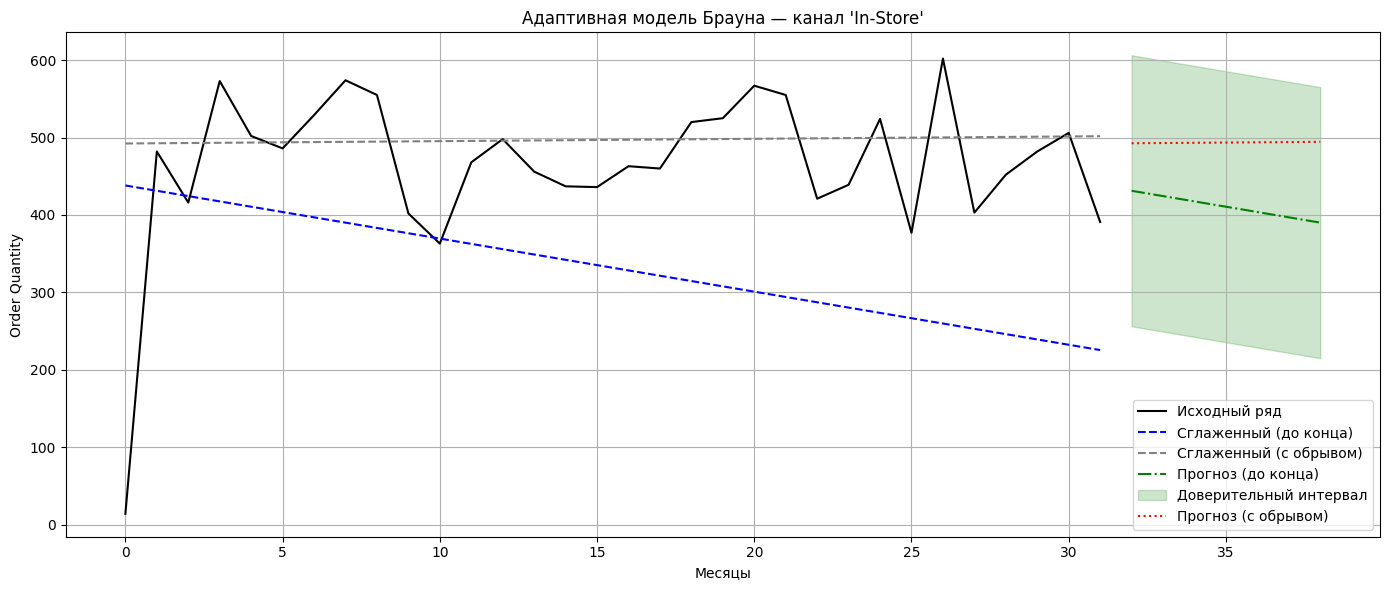

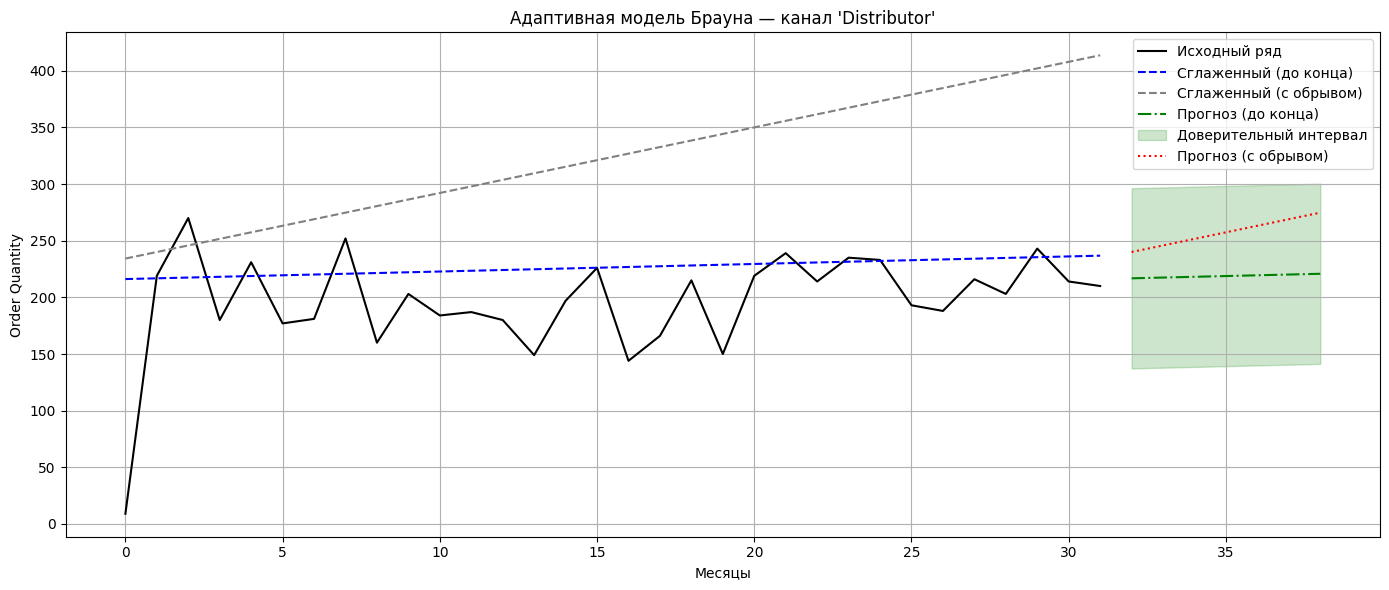

In [113]:
# Построение графиков по всем каналам
alpha = 0.3
forecast_steps = 7

for channel in selected_channels:
    series = monthly[channel].values

    fitted_all, forecast_all, ci_all = brown_forecast(series, alpha, forecast_steps)
    fitted_partial, forecast_partial, ci_partial = brown_forecast(series, alpha, forecast_steps, stop_at=len(series) - forecast_steps)

    t = np.arange(len(series))
    future_t = np.arange(len(series), len(series) + forecast_steps)

    plt.figure(figsize=(14, 6))
    plt.plot(t, series, label="Исходный ряд", color="black")
    plt.plot(t, fitted_all, label="Сглаженный (до конца)", linestyle="--", color="blue")
    plt.plot(t, fitted_partial, label="Сглаженный (с обрывом)", linestyle="--", color="gray")

    plt.plot(future_t, forecast_all, label="Прогноз (до конца)", linestyle="-.", color="green")
    plt.fill_between(future_t, np.array(forecast_all)-ci_all, np.array(forecast_all)+ci_all,
                     color='green', alpha=0.2, label="Доверительный интервал")

    plt.plot(future_t, forecast_partial, label="Прогноз (с обрывом)", linestyle=":", color="red")
    plt.title(f"Адаптивная модель Брауна — канал '{channel}'")
    plt.xlabel("Месяцы")
    plt.ylabel("Order Quantity")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

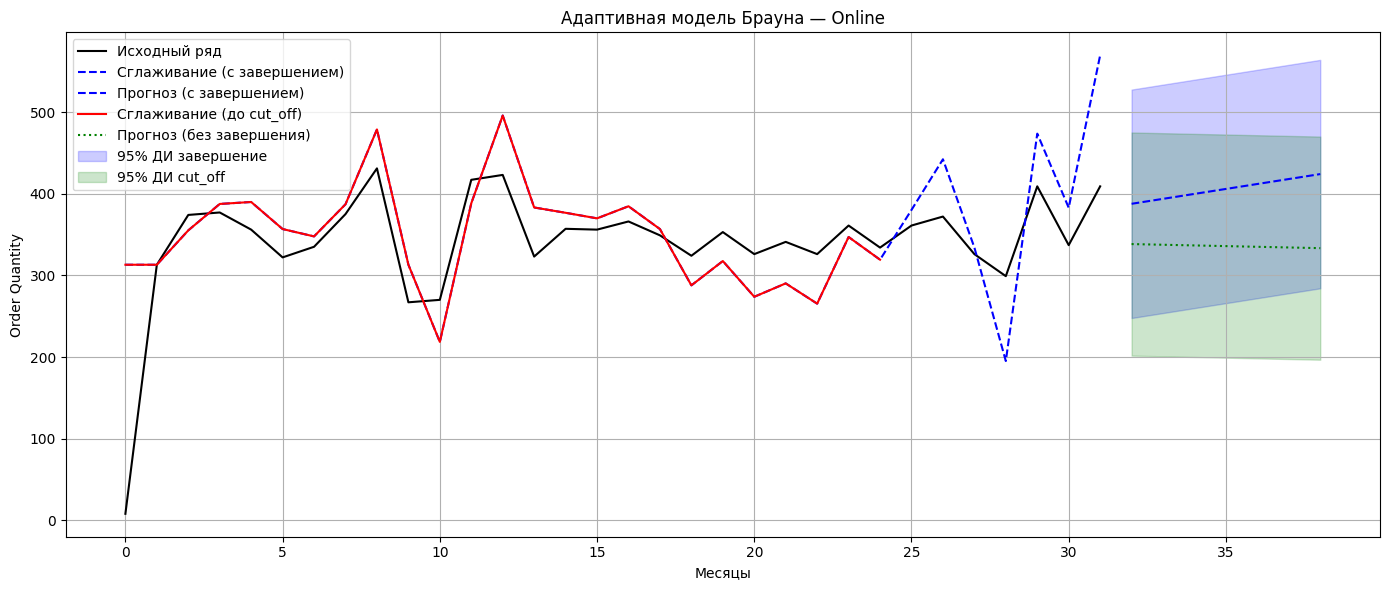

Online
Интервальный прогноз (с завершением): (284.1400678816489, 563.8977341437608)
Интервальный прогноз (без завершения): (196.68597588735284, 469.9530944542822)
----------------------------------------------------------------------


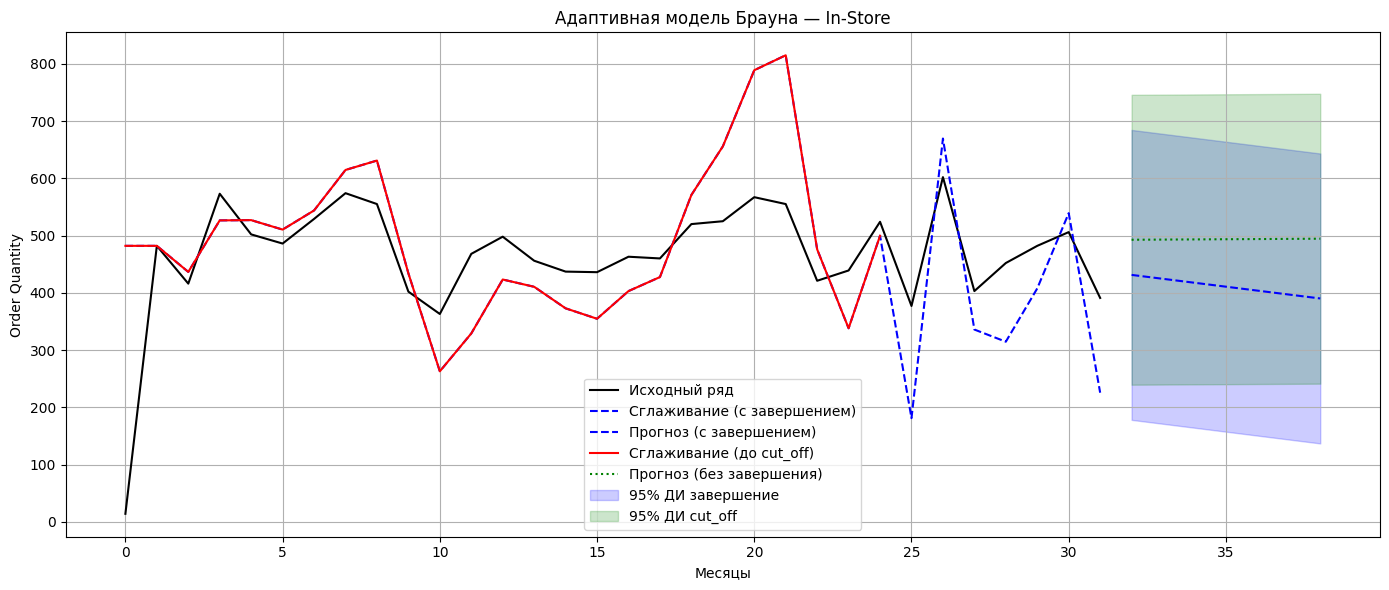

In-Store
Интервальный прогноз (с завершением): (136.89332528363457, 643.2925369601198)
Интервальный прогноз (без завершения): (241.26182489001417, 747.6407652927516)
----------------------------------------------------------------------


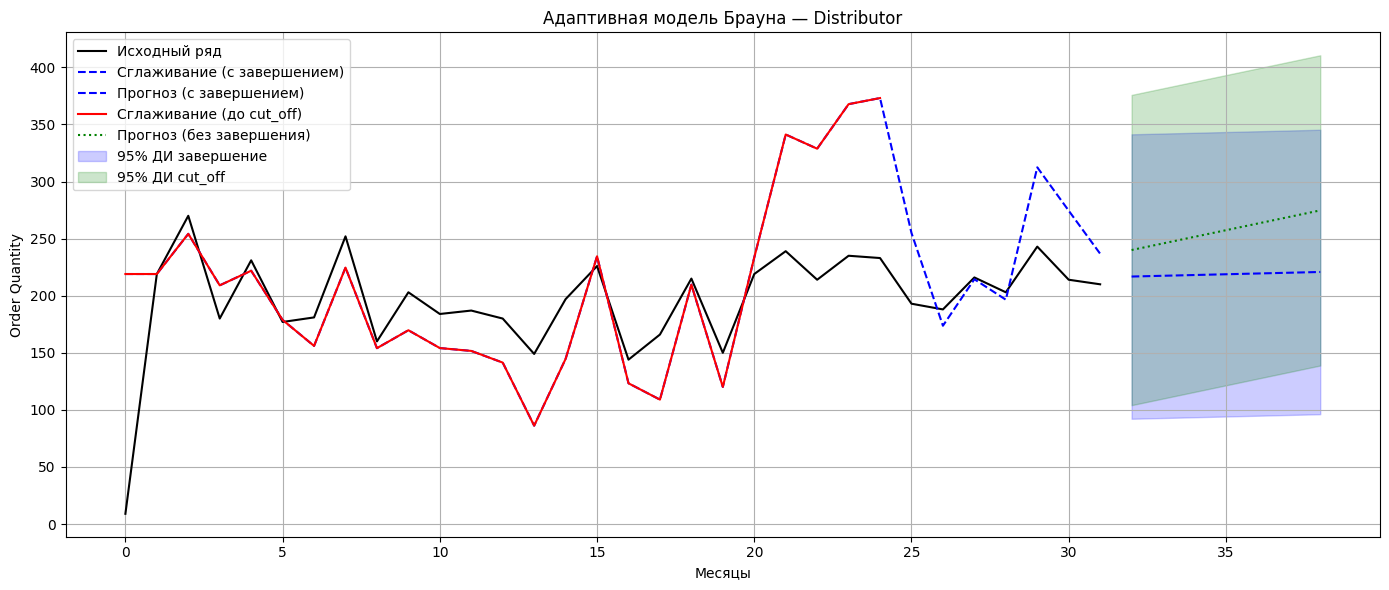

Distributor
Интервальный прогноз (с завершением): (96.21587851792668, 345.368466993711)
Интервальный прогноз (без завершения): (138.87002750698116, 410.5996013647597)
----------------------------------------------------------------------


In [119]:
def brown_model(series, alpha=0.3, forecast_steps=7, cut_off=None):
    if cut_off:
        series = series[:cut_off]

    S1 = [series[1]]
    S2 = [series[1]]
    for t in range(1, len(series)):
        S1.append(alpha * series[t] + (1 - alpha) * S1[-1])
        S2.append(alpha * S1[-1] + (1 - alpha) * S2[-1])

    S1 = np.array(S1)
    S2 = np.array(S2)
    a_t = 2 * S1[-1] - S2[-1]
    b_t = (alpha / (1 - alpha)) * (S1[-1] - S2[-1])

    forecast = [a_t + b_t * k for k in range(1, forecast_steps + 1)]
    fitted = [2 * S1[i] - S2[i] + (alpha / (1 - alpha)) * (S1[i] - S2[i]) * i for i in range(len(series))]

    residuals = series[:len(fitted)] - fitted
    stderr = np.std(residuals)
    ci = 1.96 * stderr
    return np.array(fitted), np.array(forecast), (forecast[-1] - ci, forecast[-1] + ci)

# Параметры
alpha = 0.3
forecast_steps = 7
cut_off = len(series) - forecast_steps

for channel in selected_channels:
    series = monthly[channel].values
    cut_off = len(series) - forecast_steps

    fitted_full, forecast_full, interval_full = brown_model(series, alpha, forecast_steps)
    fitted_cut, forecast_cut, interval_cut = brown_model(series, alpha, forecast_steps, cut_off)

    t = np.arange(len(series))
    future_t = np.arange(len(series), len(series) + forecast_steps)

    plt.figure(figsize=(14, 6))
    plt.plot(t, series, label="Исходный ряд", color='black')
    plt.plot(t, fitted_full, label="Сглаживание (с завершением)", linestyle='--', color='blue')
    plt.plot(future_t, forecast_full, label="Прогноз (с завершением)", linestyle='--', color='blue')
    plt.plot(t[:cut_off], fitted_cut, label="Сглаживание (до cut_off)", linestyle='-', color='red')
    plt.plot(future_t, forecast_cut, label="Прогноз (без завершения)", linestyle=':', color='green')
    plt.fill_between(future_t, forecast_full - interval_full[1] + forecast_full[-1],
                            forecast_full + interval_full[1] - forecast_full[-1],
                            color='blue', alpha=0.2, label='95% ДИ завершение')

    plt.fill_between(future_t, forecast_cut - interval_cut[1] + forecast_cut[-1],
                            forecast_cut + interval_cut[1] - forecast_cut[-1],
                            color='green', alpha=0.2, label='95% ДИ cut_off')

    plt.title(f"Адаптивная модель Брауна — {channel}")
    plt.xlabel("Месяцы")
    plt.ylabel("Order Quantity")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"{channel}")
    print("Интервальный прогноз (с завершением):", interval_full)
    print("Интервальный прогноз (без завершения):", interval_cut)
    print("-" * 70)